# Analysis of the L1-21-J impact event on the Moon

*"Location, orbit and energy of a meteoroid impacting the moon during the Lunar Eclipse of January 21, 2019* by Jorge I. Zuluaga, Pablo A. Cuartas, Jonathan Ospina, Sergio López, Fritz Pichardo & Karl Peña

## External modules and useful routines

In [1]:
###################################################################
#EXTERNAL MODULES
###################################################################
BDIR="./"
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.interpolate import interp1d as interpolate
from scipy.integrate import quad as integrate
import statistics as stats
import spiceypy as spy
from copy import deepcopy
from mpl_toolkits.basemap import Basemap as Map,shiftgrid as Grid
from tqdm import tqdm

%matplotlib nbagg

###################################################################
#INITIALIZE SPICE
###################################################################
spy.furnsh(BDIR+"kernels/de430.bsp")
spy.furnsh(BDIR+"kernels/naif0012.tls")
spy.furnsh(BDIR+"kernels/pck00010.tpc")
spy.furnsh(BDIR+"kernels/moon_pa_de421_1900-2050.bpc")

###################################################################
#CONSTANTS AND MACROS
###################################################################
#Angle conversion
DEG=np.pi/180
RAD=1/DEG

#Tons of TNT
TTNT=4.184e9 #J

#Regolith density
RHO_REG=1600 #kg/m^3

#Useful package routines
norm=np.linalg.norm

###################################################################
#ROUTINES
###################################################################
def str2vec(str):
    v=np.array([float(x) for x in str.split(" ")])
    return v
def angle(u,v):
    return np.arccos(np.dot(u,v)/(norm(u)*norm(v)))*180/np.pi

def randomX(xs,ps,N=100):
    """
        Generate random values of x given a normalized histogram (ps)
    """
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    Fi=interpolate(Ps,xs)
    u=np.random.rand(N,1)
    us=Ps.min()+u*(Ps.max()-Ps.min())
    xrs=Fi(us)
    return xrs

def ipercs(xs,ps,qpercs):
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    fi=interpolate(Ps,xs)
    return fi(np.array(qpercs)/100.0)

def Gmag(coefs,r=1,g=1,b=1,x=1,y=1):
    """
    coefs: Coefficients
    r,g,b: Counts in each band
    """
    mG=coefs[0]+coefs[1]*np.log(r)+coefs[2]*np.log(g)+coefs[3]*np.log(b)
    return mG                                         

def chiSquare(coefs,stars=None,verbose=False):
    chisq=0
    dGs=[]
    for ind in stars.index[1:]:
        star=stars.loc[ind]
        Gteo=Gmag(coefs,star["Red"],star["Blue"],star["Green"])
        Gobs=float(star["G"])
        dGs+=[np.abs(Gteo-Gobs)]
        if verbose:print(f"{star['Starname']}:Teo={Gteo},Obs={Gobs},dM={dGs[-1]}")
        dG=0.05
        chisq+=(Gteo-Gobs)**2/dG**2
    if verbose:return chisq,dGs
    return chisq
                         
#Convert Az,h into RA, DEC at a location lon,lat,alt on the moon
def loc2Sky(et,Az,h,lon,lat,alt,bodyid="MOON",frameid="IAU_MOON"):
    """
    Az,h,lon,lat in degress.
    alt in km.
    
    Return RA(deg) and DEC(deg)
    
    Example: 
        Az=29.9670;h=19.2504
        loc2Sky(et,Az,h,LON_MOON,LAT_MOON,ALT_MOON,"MOON","IAU_MOON")
    """
    #Rectangular position
    r_local=spy.latrec(1,Az*DEG,h*DEG)
    
    #Size of the object
    n,rs=spy.bodvrd("MOON","RADII",3)
    Re=rs[0];Rp=rs[2]
    f=(Re-Rp)/Re
    geopos=spy.georec(lon*DEG,lat*DEG,alt,Re,f)

    #Local to Body reference frame transformation
    normal=spy.surfnm(Re,Re,Rp,geopos)
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    Local2Body=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    
    #Body to J2000
    Body2j2000=spy.pxform(frameid,"J2000",et)
    
    #Transform vector from local to IAU moon
    r_body=spy.mxv(Local2Body,r_local)
    r_j2000=spy.mxv(Body2j2000,r_body)

    #J2000 coordinates
    r,RA,DEC=spy.reclat(r_j2000)
    RA=RA+2*np.pi if RA<0 else RA
    return RA*RAD,DEC*RAD   

## Useful constants

In [2]:
#impact time and location
IMPACT_DATA="grt-20190121044138-7AE3F0"
IMPACT_SUFFIX="lat_-2.94288e+01__lon_-6.81674e+01"
IMPACT_FIGDIR=f"{BDIR}/figures/{IMPACT_DATA}/"

IMPACT_DATE="01/21/2019 04:41:38 UTC"
IMPACT_LOC=dict(
    lon=-29.428816, #degrees, 29°25'43.74"S
    lat=-68.167435, #degrees, 68°10'2.77"O
    alt=0.510 #km
)
IMPACT_FLASH=9.0/30.0

t=spy.str2et(IMPACT_DATE)
dt=spy.deltet(t,"et")
IMPACT_ET=t-dt
print(f"Time of the eclipse: {IMPACT_DATE} (TDB = {IMPACT_ET}, Delta t = {dt}")

#Instrument properties
#LaLoma (San Vicente Ferrer, Colombia)
LALOMA_F=0.73
LALOMA_FL=2700.0 #mm
LALOMA_D=635 #mm
ZWO_COLS=4656.0 #px
ZWO_ROWS=3520.0 #px
ZWO_WIDTH=17.5 #mm
ZWO_HEIGHT=13.4 #mm

#Moon distance at the time of the impact
moonpos,tf=spy.spkezr("MOON",IMPACT_ET,"J2000","NONE","EARTH")
MOON_DISTANCE=norm(moonpos[:4]) #km
print(f"Moon distance at the time of impact (km): {MOON_DISTANCE}")

#Location of the Earth at the time of the eclipse
r,RA_EARTH,DEC_EARTH=spy.reclat(-moonpos[:3])
RA_EARTH=24+RA_EARTH*RAD/15 if RA_EARTH<0 else RA_EARTH*RAD/15
DEC_EARTH*=RAD
print(f"Position of the Earth as seen from the moon: {RA_EARTH,DEC_EARTH}")

#RA_EARTH=20+11.0/60.0+9.58/3600.0
#DEC_EARTH=-(20+1.0/60.0+24.2/3600.0)

#Filter calibration, http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php
NG=2.500e-11 #W/m^2/nm
G0=0.03
DLAMBDA=420.360 #Weff, nm

#Moon size
n,rs=spy.bodvrd("MOON","RADII",3)
RMOON=rs[0]
FMOON=0.0
print(f"Moon equatorial radius (km): {RMOON}")

#Moon reference frame matrix transformation
Moon2j2000=spy.pxform("IAU_MOON","J2000",IMPACT_ET)

plt.ion()

Time of the eclipse: 01/21/2019 04:41:38 UTC (TDB = 601317698.0, Delta t = 69.18449230785387
Moon distance at the time of impact (km): 357745.19348597113
Position of the Earth as seen from the moon: (20.166039257679454, -20.436535879618923)
Moon equatorial radius (km): 1737.4


## Images and instruments

In [3]:
#Theoretical spatial resolution of LaLoma telescope
pxsize=ZWO_WIDTH/(LALOMA_F*LALOMA_FL)/ZWO_COLS
pxsize_km=pxsize*MOON_DISTANCE
#At 70 degrees inclination
pxsize_inc=pxsize_km/np.cos(IMPACT_LOC["lat"]*DEG)
print(f"Theoretical angular resolution = {pxsize*180/np.pi*3600} arcsec")
print(f"Theoretical linear resolution = {pxsize_km} km")
print(f"Theoretical linear resolution (@{np.abs(IMPACT_LOC['lat'])} deg) = {pxsize_inc} km")

Theoretical angular resolution = 0.3933358994645062 arcsec
Theoretical linear resolution = 0.6822008563610164 km
Theoretical linear resolution (@68.167435 deg) = 1.8343885961381754 km


## Orbital analysis

### Read data

In [4]:
data_rays=np.loadtxt(BDIR+f"data/{IMPACT_DATA}/rays-{IMPACT_SUFFIX}.data.phys")
data_rays_prob=np.loadtxt(BDIR+f"data/{IMPACT_DATA}/rays-{IMPACT_SUFFIX}.data.prob")
Nrays=len(data_rays)
print(f"Number of test trajectories read: {Nrays}")

Number of test trajectories read: 41167


### Posterior probability distribution of key properties 

In [5]:
properties=[
    dict(indice=0,property="elevation",factor=30),
    dict(indice=2,property="vimp",factor=5),
    dict(indice=1,property="azimuth",factor=50)
]
pprob=data_rays_prob[:,7]
print("Computed rays:",len(pprob))
for qprop in properties:
    print(f"Computing ppd for {qprop['property']}")
    xs=data_rays[:,qprop["indice"]]
    xun=np.unique(xs)
    Nun=len(xun)
    print("\tUnique values of property:",Nun)

    # Range of elevations                                                                                                                                                                                                                                     
    xmin=xs.min()
    xmax=xs.max()
    print("\tRanges:",xmin,xmax)

    # Create boxes                                                                                                                                                                                                                                            
    Nb=int(Nun/qprop["factor"])
    print("\tSampling points:",Nb)
    xb=np.linspace(xmin,1.01*xmax,Nb,endpoint=False)
    dxb=xb[1]-xb[0]

    # Compute probabilities                                                                                                                                                                                                                                   
    P=0
    hb=np.zeros(Nb)
    for i,x in tqdm(enumerate(xs)):
        p=pprob[i]
        P+=p
        n=int((x-xmin)/dxb)
        hb[n]+=p

    hb=np.array(hb)
    hb/=P

    #Save histogram
    fname=BDIR+f"data/{qprop['property']}-marginal.dat"
    print(f"\tSaving {fname}")
    np.savetxt(fname,np.vstack((xb,hb)).transpose())

22408it [00:00, 224078.08it/s]

Computed rays: 41167
Computing ppd for elevation
	Unique values of property: 498
	Ranges: 0.27798 83.332
	Sampling points: 16


41167it [00:00, 194921.49it/s]
17396it [00:00, 173952.70it/s]

	Saving ./data/elevation-marginal.dat
Computing ppd for vimp
	Unique values of property: 100
	Ranges: 2.7972 44.058
	Sampling points: 20


41167it [00:00, 213066.44it/s]
0it [00:00, ?it/s]

	Saving ./data/vimp-marginal.dat
Computing ppd for azimuth
	Unique values of property: 498
	Ranges: 0.27282 359.06
	Sampling points: 9


41167it [00:00, 224873.85it/s]


	Saving ./data/azimuth-marginal.dat


### Impact velocity statistics

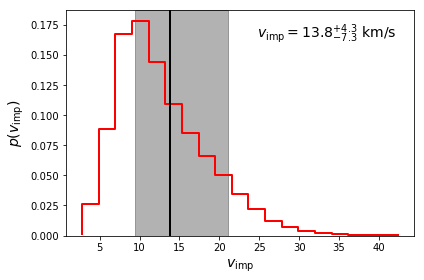

In [6]:
#Posterior probability distribution of impact velocities
data=np.loadtxt(BDIR+"data/vimp-marginal.dat")
vimps=data[:,0]
pvs=data[:,1]
v1,vm,v2=ipercs(vimps,pvs,[15.0,50.0,85.0])
mv=vm-v1;pv=v2-vm

#Plot
fig=plt.figure()
ax=fig.gca()

ax.step(vimps,pvs,color='r',lw=2)

ax.set_xlabel(r"$v_{\rm imp}$",fontsize=14)
ax.set_ylabel(r"$p(v_{\rm imp})$",fontsize=14)

ax.axvspan(v1,vm,color='k',alpha=0.3)
ax.axvline(vm,color='k',lw=2)
ax.axvspan(vm,v2,color='k',alpha=0.3)

#ax.set_title("L1-J-21 Impact Velocity",fontsize=18)

ax.text(0.95,0.95,r"$v_{\rm imp}=%.1lf^{+%.1lf}_{-%.1lf}$ km/s"%(vm,mv,pv),
        transform=ax.transAxes,ha='right',va='top',fontsize=14)

ymin,ymax=ax.get_ylim()
ax.set_ylim((0,ymax))

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-vimp-ppd.png")

### Incident angle statistics

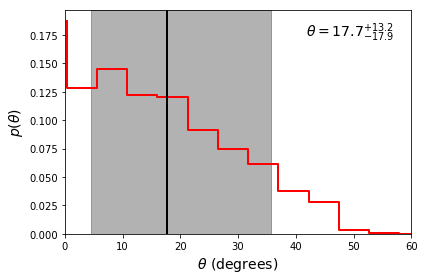

In [7]:
#Posterior probability distribution of impact velocities
data=np.loadtxt(BDIR+"data/elevation-marginal.dat")
angles=data[:,0]
pas=data[:,1]
v1,vm,v2=ipercs(angles,pas,[15.0,50.0,85.0])
mv=vm-v1;pv=v2-vm

#Figure
fig=plt.figure()
ax=fig.gca()

ax.step(angles,pas,color='r',lw=2)

ax.set_xlabel(r"$\theta$ (degrees)",fontsize=14)
ax.set_ylabel(r"$p(\theta)$",fontsize=14)

ax.axvspan(v1,vm,color='k',alpha=0.3)
ax.axvline(vm,color='k',lw=2)
ax.axvspan(vm,v2,color='k',alpha=0.3)

ax.text(0.95,0.95,r"$\theta=%.1lf^{+%.1lf}_{-%.1lf}$"%(vm,mv,pv),
        transform=ax.transAxes,ha='right',va='top',fontsize=14)

ymin,ymax=ax.get_ylim()
ax.set_ylim((0,ymax))
ax.set_xlim((0,60))

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-elevation-ppd.png")

### Distribution of Radiants

In [8]:
#Build 2D histogram
RAmin=0.0;RAmax=360;NRA=10;dRA=(RAmax-RAmin)/NRA
DECmin=-90.0;DECmax=90.0;NDEC=10;dDEC=(DECmax-DECmin)/NDEC

#Run over all combinations
hrd=np.zeros((NDEC,NRA))

j=0
for i in tqdm(range(len(data_rays))):

    #Topocentric coordinates
    Az=data_rays[i,1]
    h=data_rays[i,0]

    #J2000 coordinates
    RA,DEC=loc2Sky(IMPACT_ET,Az,h,
                   IMPACT_LOC["lon"],IMPACT_LOC["lat"],IMPACT_LOC["alt"],
                   "MOON","IAU_MOON")
    #print(Az,h,RA/15,DEC)
    
    nRA=int((RA-RAmin)/dRA)
    nDEC=int((DEC-DECmin)/dDEC)

    if nRA>=NRA or nDEC>=NDEC:continue
    hrd[nDEC,nRA]+=1
    j+=1

100%|██████████| 41167/41167 [00:19<00:00, 2078.27it/s]


In [9]:
#Surface of the moon
sRA=[]
sDEC=[]
h=0
for Az in np.linspace(0,360,100):
    RA,DEC=loc2Sky(IMPACT_ET,Az,h,IMPACT_LOC["lon"],IMPACT_LOC["lat"],IMPACT_LOC["alt"],
                   "MOON","IAU_MOON")
    sRA+=[RA]
    sDEC+=[DEC]
sRA=np.array(sRA);sDEC=np.array(sDEC)

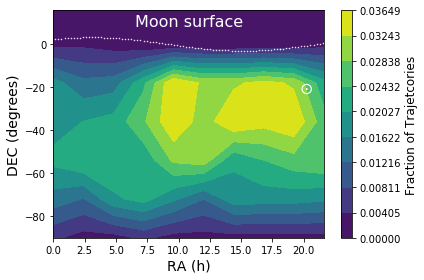

In [10]:
#Map
RAs,DECs=np.meshgrid(np.arange(RAmin,RAmax,dRA),np.arange(DECmin,DECmax,dDEC))
hrd/=hrd.sum()

fig=plt.figure()
ax=fig.gca()

c=ax.contourf(RAs/15.0,DECs,hrd,levels=np.linspace(hrd.min(),hrd.max(),10)) #,cmap="YlOrBr")
cbar=fig.colorbar(c)
cbar.ax.set_ylabel('Fraction of Trajetcories',fontsize=12)

#ax.plot(RA_EARTH,DEC_EARTH,'wo')
ax.plot(sRA/15.0,sDEC,'w.',ms=1)

ax.set_ylim((-90.0,5*max(sDEC)))
ax.set_xlim((0,RAs.max()/15.0))

ax.text(RA_EARTH,DEC_EARTH,r'$\odot$',ha='center',va='center',color='w',fontsize=16)
ax.text(0.5,0.95,"Moon surface",ha='center',va='center',transform=ax.transAxes,color='w',fontsize=16)

ax.set_xlabel("RA (h)",fontsize=14)
ax.set_ylabel("DEC (degrees)",fontsize=14)

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-RA_DEC-map.png")

### Orbital Map

In [11]:
amin=0.5;amax=2.5;Na=10;da=(amax-amin)/Na
emin=0.0;emax=1.0;Ne=10;de=(emax-emin)/Ne

hae=np.zeros((Na,Ne))
for i in tqdm(range(Nrays)):
    q=data_rays[i,9]
    e=data_rays[i,10]
    if e>=1:continue
    a=q/(1-e)
    na=int((a-amin)/da)
    ne=int((e-emin)/de)
    if na>=Na or ne>=Ne:continue
    hae[ne,na]+=1
Nt=hae.sum()

100%|██████████| 41167/41167 [00:00<00:00, 95459.95it/s]


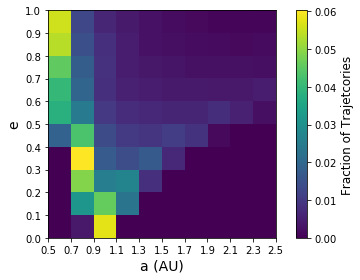

In [12]:
#Figure
A,E=np.meshgrid(np.arange(amin,amax,da),np.arange(emin,emax,de))
fig=plt.figure()
ax=fig.gca()

im=ax.imshow(hae/Nt,origin='lower')
cbar=fig.colorbar(im)
cbar.ax.set_ylabel('Fraction of Trajetcories',fontsize=12)

ax.set_xlabel("a (AU)",fontsize=14)
ax.set_ylabel("e",fontsize=14)

xts=[]
xtl=[]
for i in np.arange(0.0,Na+1,1):
    xts+=[i-0.5]
    xtl+=["%.1f"%(amin+i*da)]
t=ax.set_xticks(xts)
t=ax.set_xticklabels(xtl)

xts=[]
xtl=[]
for i in np.arange(0.0,Ne+1,1):
    xts+=[i-0.5]
    xtl+=["%.1f"%(emin+i*de)]
t=ax.set_yticks(xts)
t=ax.set_yticklabels(xtl)

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-ae-map.png")

## Photometry

In [13]:
data_rays=np.loadtxt(BDIR+f"data/{IMPACT_DATA}/rays-{IMPACT_SUFFIX}.data.phys")
stars=pd.read_csv(BDIR+f"data/{IMPACT_DATA}/photometry.csv")
for key in "B","V","G":stars[key]=stars[key].apply(lambda x:x.replace(',','.'))
impact=stars.loc[9].copy()
stars.drop(9,inplace=True)

In [14]:
coefs=[]
coefs+=[24.35475129]
coefs+=[0.17248805]
coefs+=[0.44909602]
coefs+=[1.93560511]
G=Gmag(coefs,stars.loc[0,"Red"],stars.loc[0,"Blue"],stars.loc[0,"Green"])
chisq=chiSquare(coefs,stars,True)
print(f"Test G-mag = {G}")
print(f"Test chisquare = {chisq}")

BD+20 2009:Teo=45.87234458642629,Obs=10.4423,dM=35.43004458642629
BD+20 2007:Teo=46.69281649382823,Obs=9.7906,dM=36.902216493828234
BD+20 2005:Teo=47.71103846801377,Obs=8.6293,dM=39.08173846801377
BD+21 1766:Teo=47.903476152854815,Obs=8.3523,dM=39.551176152854815
BD+21 1779:Teo=47.684458586836044,Obs=8.9471,dM=38.737358586836045
BD+21 1777:Teo=46.387141930648745,Obs=9.6792,dM=36.707941930648744
TYC 1385-899-1:Teo=45.681138579078805,Obs=10.0131,dM=35.668038579078804
TYC 1385-939-1:Teo=44.62320087709288,Obs=10.3526,dM=34.270600877092875
Test G-mag = 47.64725093167365
Test chisquare = (4401391.387973822, [35.43004458642629, 36.902216493828234, 39.08173846801377, 39.551176152854815, 38.737358586836045, 36.707941930648744, 35.668038579078804, 34.270600877092875])


In [15]:
#Minimize
solution=minimize(chiSquare,coefs,args=(stars,False),tol=1e-5)
print(solution)

#Test Solution
chisq,dGs=chiSquare(solution.x,stars,verbose=True)
dG=np.mean(dGs)
print(f"Mean magnitude fit error:{dG}")

      fun: 6.602885449167282
 hess_inv: array([[ 0.06378907,  0.00068642, -0.00071408, -0.00731201],
       [ 0.00068642,  0.01668852,  0.00753168, -0.02450347],
       [-0.00071408,  0.00753168,  0.00496006, -0.0124912 ],
       [-0.00731201, -0.02450347, -0.0124912 ,  0.03812656]])
      jac: array([0.00000000e+00, 1.57356262e-05, 3.75509262e-06, 1.51991844e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 203
      nit: 10
     njev: 32
   status: 2
  success: False
        x: array([23.66202139,  0.18580187,  0.75506325, -2.56553377])
BD+20 2009:Teo=10.40336964795436,Obs=10.4423,dM=0.03893035204563944
BD+20 2007:Teo=9.831578774493131,Obs=9.7906,dM=0.04097877449313181
BD+20 2005:Teo=8.708465595281524,Obs=8.6293,dM=0.07916559528152334
BD+21 1766:Teo=8.312023963832225,Obs=8.3523,dM=0.040276036167774976
BD+21 1779:Teo=8.918349790545427,Obs=8.9471,dM=0.028750209454573294
BD+21 1777:Teo=9.622782118746109,Obs=9.6792,dM=0.05641788125389091
TYC 1385

In [16]:
m=Gmag(solution.x,impact["Red"],impact["Blue"],impact["Green"],impact["Row"],impact["Col"])
print(f"Magnitude without exposure correction:",m)

Magnitude without exposure correction: 11.608517707928296


In [17]:
#Exposure time of the reference stars
TEXP=20.0
#Corrected magnitude by exposure
G=m-2.5*np.log10(TEXP/IMPACT_FLASH)
print(f"Total average G mag of the flash: {G}")

Total average G mag of the flash: 7.048745855567499


## Energy of the impact

In [18]:
#Luminous energy
f=2
Er=NG*10**((-G+G0)/2.5)*DLAMBDA*f*np.pi*(MOON_DISTANCE*1e3)**2
logEr=np.log10(Er)
dlogEr=dG/G*logEr
print(f"Luminous energy (log): {logEr} +/- {dlogEr}")

Luminous energy (log): 7.119390533114319 +/- 0.041505464974669934


In [19]:
#Luminous efficiency
logeta_min=np.log10(1.8e-3)
logeta_max=np.log10(3.4e-3)
logeta_mean=(logeta_min+logeta_max)/2
dlogeta=logeta_mean-logeta_min

In [20]:
#Kinetic energy
logK=logEr-logeta_mean
dlogK=np.sqrt(dlogEr**2+dlogeta**2)
print(f"Kinetic energy (log): {logK} +/- {dlogK}")
print(f"Range of kinetic energy in tons: {10**(logK-dlogK)/TTNT}-{10**(logK+dlogK)/TTNT} tons of TNT")

Kinetic energy (log): 9.726014822041538 +/- 0.14420540600757878
Range of kinetic energy in tons: 0.9124682045701461-1.7726726827750534 tons of TNT


## Meteoroid and crater size

### Random values of primary quantities 

In [21]:
#Generate random values of the key quantities
N=1000
#Random kinetic energy
logKs=np.random.normal(logK,dlogK,N)
Ks=10**logKs
#Random impact speed
vrs=randomX(vimps,pvs,N)
#Random impact angle
thetas=randomX(angles,pas,N)
#Random densities
u=np.random.rand(N)
rhos=np.zeros(N)
rhos[(u<0.01)]=1000
rhos[(u>=0.01)*(u<0.59)]=2500
rhos[(u>=0.59)]=3700

### Derived quantities

In [22]:
#Mass
Ms=2*Ks/(vrs*1e3)**2
logMs=np.log10(Ms)
#Diameter
Ds=2*(3*Ms/(3*np.pi*rhos))**(1./3)
#Crater diameter
dcs=0.25*rhos**(1./6.)*RHO_REG**(-0.5)*Ks**0.29*(np.sin(thetas*DEG))**(1./3.)

In [23]:
#Basic statistics
print(f"Median impactor mass: {np.percentile(Ms,50)} kg")
print(f"Median impactor diameter: {np.percentile(Ds,50)} m")
print(f"Median crater size: {np.percentile(dcs,50)} m")

Median impactor mass: 55.10002503913701 kg
Median impactor diameter: 0.36299161556502063 m
Median crater size: 10.421355337417669 m


### Posterior probability distributions

Generating statistics of logMs...


/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


	Value: $\log(M)$$=1.7^{+0.40}_{-0.36}$ [kg]
	Creating figure file .//figures/grt-20190121044138-7AE3F0//l21j-logMs-ppd.png
Generating statistics of Ds...
	Value: $D$$=0.4^{+0.10}_{-0.12}$ m
	Creating figure file .//figures/grt-20190121044138-7AE3F0//l21j-Ds-ppd.png
Generating statistics of dcs...
	Value: $d$$=10.4^{+4.01}_{-2.88}$ m
	Creating figure file .//figures/grt-20190121044138-7AE3F0//l21j-dcs-ppd.png


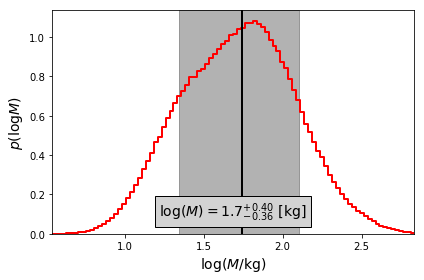

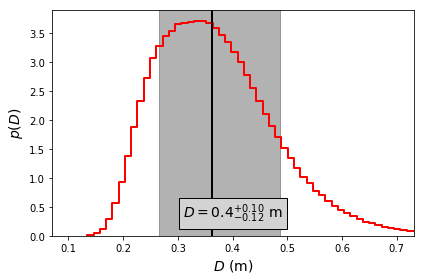

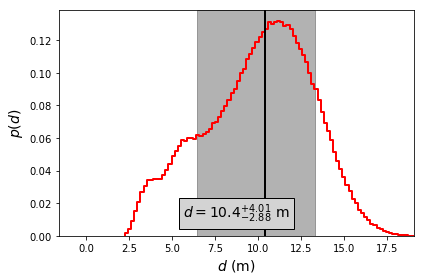

In [24]:
properties=[
    dict(name="$\log(M)$",units="[kg]",symbol="logMs",xlabel=r"$\log(M/{\rm kg})$",ylabel=r"$p(\log M)$"),
    dict(name="$D$",units="m",symbol="Ds",xlabel=r"$D$ (m)",ylabel=r"$p(D)$"),
    dict(name="$d$",units="m",symbol="dcs",xlabel=r"$d$ (m)",ylabel=r"$p(d)$"),
]
plt.ioff()
for q in properties[:]:
    
    print(f"Generating statistics of {q['symbol']}...")
    
    #Statistics
    exec(f"vs=deepcopy({q['symbol']})")
    exec(f"hs,xs=np.histogram({q['symbol']},100,normed=True)")
    xms=(xs[1:]+xs[:-1])/2
    #Error
    x1,xm,x2=np.percentile(vs,[15,50,85])
    mv=xm-x1;pv=x2-xm
    x1,xm,x2

    #Plot distributions
    fig=plt.figure()
    ax=fig.gca()
    ax.step(xms,hs,color='r',lw=2)

    ax.set_xlabel(q["xlabel"],fontsize=14)
    ax.set_ylabel(q["ylabel"],fontsize=14)

    ax.axvspan(x1,xm,color='k',alpha=0.3)
    ax.axvline(xm,color='k',lw=2)
    ax.axvspan(xm,x2,color='k',alpha=0.3)

    value=r"%s$=%.1lf^{+%.2lf}_{-%.2f}$ %s"%(q["name"],xm,mv,pv,q["units"])
    print(f"\tValue: {value}")
    ax.text(0.5,0.1,value,
            transform=ax.transAxes,ha='center',va='center',fontsize=14,bbox=dict(facecolor='lightgray'))

    ymin,ymax=ax.get_ylim()
    ax.set_ylim((0,ymax))
    ax.set_xlim((x1-2*mv,x2+2*pv))
    fname=f"{IMPACT_FIGDIR}/l21j-{q['symbol']}-ppd.png"
    print(f"\tCreating figure file {fname}")
    fig.savefig(fname)
    fig.tight_layout()
    del(fig)